# 1. Library importation

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

#2. Audio file preprocessing


In [ ]:
import os
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display


#to play audio
import IPython.display as ipd

## 2.1 LSTM preprocessing

In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
zcr = []
mfcc = []
spectral_cent = []
spectral_roll = []
chroma_st = []
emotions = []

# Initialize variables
total_length = 173056 
# desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/TESS' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) 
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.chroma_stft(y=final_x, sr=sr) 
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      f4 = librosa.feature.spectral_centroid(y=final_x, sr=sr) # spectral centroid
      f5 = librosa.feature.spectral_rolloff(y=final_x, sr=sr) # spectral roll off
      
   # Emotion extraction from the different databases
      name = find_emotion_T(file)          

   # Filling the data lists  
      chroma_st.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      spectral_cent.append(f4)
      spectral_roll.append(f5)
      emotions.append(name) 

#3. Data setup

In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)

f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

f_spectral_cent = np.asarray(spectral_cent).astype('float32')
f_spectral_cent = np.swapaxes(f_spectral_cent,1,2)

f_spectral_roll = np.asarray(spectral_roll).astype('float32')
f_spectral_roll = np.swapaxes(f_spectral_roll,1,2)

f_chroma_st = np.asarray(chroma_st).astype('float32')
f_chroma_st = np.swapaxes(f_chroma_st,1,2)

print('ZCR shape:',f_zcr.shape)
print('MFCCs shape:',f_mfccs.shape)

print('f_spectral_cent shape:',f_spectral_cent.shape)
print('f_spectral_roll shape:',f_spectral_roll.shape)
print('f_chroma_st shape:',f_chroma_st.shape)

ZCR shape: (1400, 339, 1)
MFCCs shape: (1400, 339, 13)
f_spectral_cent shape: (1400, 339, 1)
f_spectral_roll shape: (1400, 339, 1)
f_chroma_st shape: (1400, 339, 12)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_chroma_st, f_spectral_roll, f_spectral_cent, f_zcr, f_mfccs, f_spectral_cent), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)
print(X.shape)
print(Y.shape)


(1400, 339, 29)
(1400, 1)


In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

## 3.1  Split train, val, test data and convert y to one hot vector

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.4, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, 7, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 7, dtype = 'int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1120, 339, 29)
(168, 339, 29)
(112, 339, 29)


##3.2 Save the test data

In [ ]:
# Save X,Y arrays as lists to json files.

x_test_data = x_test.tolist() 
x_test_path = 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/lstm_x_test.json' # FILE SAVE PATH
dump(obj = x_test_data, fp = x_test_path)

y_test_data = y_test.tolist() 
y_test_path = 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/lstm_y_test.json' # FILE SAVE PATH
dump(obj = y_test_data, fp = y_test_path)


'[[0], [5], [1], [4], [1], [6], [0], [5], [1], [1], [5], [1], [4], [4], [1], [1], [0], [4], [1], [2], [6], [6], [0], [4], [5], [0], [5], [0], [3], [3], [1], [2], [6], [6], [4], [4], [5], [4], [0], [0], [1], [5], [0], [1], [4], [2], [0], [4], [0], [6], [2], [4], [2], [4], [0], [3], [6], [6], [2], [3], [4], [2], [4], [0], [5], [5], [5], [6], [4], [5], [0], [0], [3], [1], [5], [0], [3], [1], [1], [5], [1], [0], [0], [6], [4], [0], [3], [1], [2], [5], [0], [3], [4], [3], [5], [4], [4], [0], [3], [1], [6], [6], [3], [5], [3], [4], [2], [5], [6], [0], [5], [6]]'

#4 Model training

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

from tensorflow.keras.layers import LSTM as KERAS_LSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, \
    Activation, BatchNormalization, MaxPooling1D

In [ ]:
# Initializing the model
model = Sequential()
model.add(layers.LSTM(64, input_shape=(X.shape[1:3]))) 
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 分类层

print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

# Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')                 
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=100, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                24064     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 28,679
Trainable params: 28,679
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
49/49 [==============================] - 9s 142ms/step - loss: 1.9248 - categorical_accuracy: 0.1696 - val_loss: 1.8639 - val_categorical_accuracy: 0.3750
Epoch 2/100
49/49 [==============================] - 6s 131ms/step - loss: 1.8121 - categorical_accuracy: 0.3304 - val_loss: 1.7257 - val_cate

#5. MODEL EVALUATION

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## 5.1 Accuracy and loss over epoches for train and val dataset

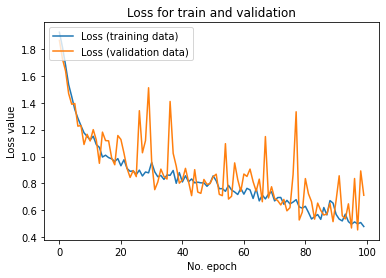

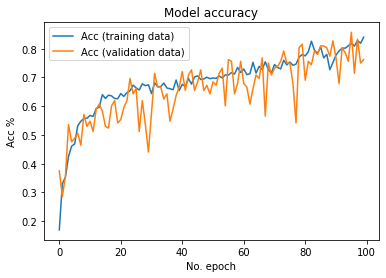

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## 5.2 Save & Load model, weights


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/lstm_model.json'
saved_weights_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/lstm_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


#6.  Test dataset evaluation

In [ ]:
!pip install json-tricks

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from json_tricks import load

import numpy as np
import os

## 6.1 Load the model and test data.

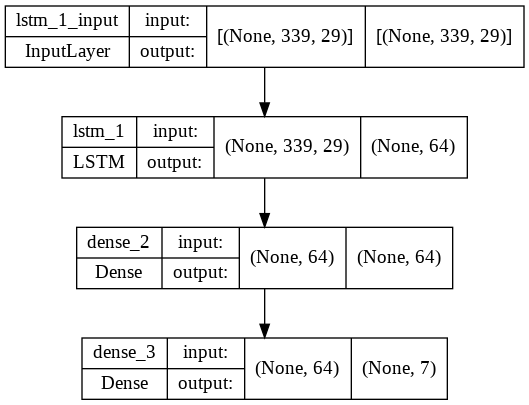

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/lstm_model.json'
saved_weights_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/lstm_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/lstm_x_test.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/lstm_y_test.json')
y_test = np.asarray(y_test).astype('int8')
print(y_test.shape)

y_test_class1 = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')
y_test_class2 = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')

(112, 1)


In [ ]:
print(x_test.shape)
print(y_test_class1.shape)
print(y_test_class2.shape)

(112, 339, 29)
(112, 7)
(112, 7)


## 6.2 Test Set Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

**Test Set Score**

In [ ]:
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 1s - loss: 0.5281 - categorical_accuracy: 0.8125 - 991ms/epoch - 248ms/step


**Test Set Confussion Matrix**

Text(0.5, 50.09375, 'Predicted emotion')

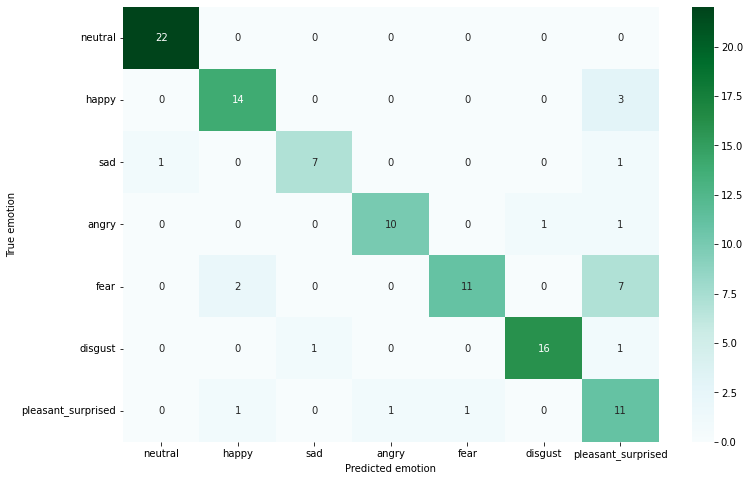

In [ ]:
# Test set Confusion matrix
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')
y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)
 
index = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'pleasant_surprised'] 

cm_df = pd.DataFrame(cm,index, index)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 1.0000
happy : 0.8235
sad : 0.7778
angry : 0.8333
fear : 0.5500
disgust : 0.8889
pleasant_surprised : 0.7857
